# 1. Setup

In [1]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor

from utils import *

In [2]:
trips = pd.read_parquet('../data/nhts/trips.parquet').disp()

729,739 rows x 31 cols; Memory: 50.8 MiB


,RawDuration,Duration,Distance,Speed,LogDistance,TripWeight,Mode,HomeBased,Purpose,VehType,...,HomeOwn,Subway,UrbanO,UrbanD,PopDensityO,PopDensityD,HouseDensityO,HouseDensityD,EmpDensityO,EmpDensityD
,<int64>,<float64>,<float64>,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,...,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>
0,15,16.182075,8.439379,31.291583,3.926362,0.006319,Drive,Yes,Social,Car,...,Own,N/A,Suburban,Suburban,Mid,Low,Mid,Low,Mid,Low


# 2. Experiment

## 2.1. Define test models, datasets & metrics

In [3]:
targets = {'LogDistance': (2, 5), 'Duration': (0, 90)}

In [4]:
ds_full = {trg: Dataset(trips, trg, rng, 0.3) for trg, rng in targets.items()}
ds_mini = {trg: Dataset(trips, trg, rng, 0.3, n=100_000) for trg, rng in targets.items()}

In [5]:
test_models = (
    ## Linear models
    ('Linear Regression', LinearRegression(), D(
        fit_intercept=[True, False],
    )),
    ('Bayesian Ridge', BayesianRidge(max_iter=1000), D(
        alpha_1=[.5e-6, 1e-6, 2e-6],
        alpha_2=[.5e-6, 1e-6, 2e-6],
        lambda_1=[.5e-6, 1e-6, 2e-6],
        lambda_2=[.5e-6, 1e-6, 2e-6],
    )),
    ('SGD Regression', SGDRegressor(max_iter=1000), D(
        alpha=[1e-05, 0.0001, 0.001, 0.01],
        l1_ratio=[0.1, 0.15, 0.2, 0.3],
        penalty=['l2', 'elasticnet'],
    )),
    ## Kernel models
    # ('Kernel Ridge', KernelRidge(), D(
    #     alpha=[0.1, 0.5, 1.0, 2.0],
    #     degree=[2, 3, 4],
    #     kernel=['linear', 'poly'],
    # )),
    ('Linear SVR', LinearSVR(dual='auto', max_iter=50_000), D(
        C=[0.5, 0.75, 1.0, 1.25, 1.5],
        epsilon=[0, 0.1, 0.2],
        loss=['epsilon_insensitive', 'squared_epsilon_insensitive']
        # degree=[2, 3, 4],
        # gamma=['scale', 'auto'],
        # kernel=['linear', 'poly'],
    )),
    ## Decision tree models
    ('Random Forest', RandomForestRegressor(n_jobs=4), D(
       n_estimators=[100, 200, 500, 750],
       max_depth=[10, 20, 30, 40],
    )),
    ('Light Gradient Boost', LGBMRegressor(
        n_jobs=4, force_row_wise=True, num_leaves=1000, verbosity=0), D(
            boosting_type=['gbdt', 'dart'],
            learning_rate=[0.05, 0.1, 0.5],
            max_depth=[10, 20, 30, 40],
            n_estimators=[100, 200, 500, 750],
    )),
    ('Extreme Gradient Boost', XGBRegressor(n_jobs=4), D(
        booster=['gbtree', 'gblinear'],
        learning_rate=[0.05, 0.1, 0.5],
        # max_depth=[10, 20, 30, 40],
        n_estimators=[100, 200, 500, 750],
    )),
)

In [6]:
metrics = D(r2=r2_score, mae=mean_absolute_error, 
            mape=mean_absolute_percentage_error, mse=mean_squared_error)

## 2.2. Cross validate models on mini dataset

In [7]:
def compare_reg_mini(models, datasets, metrics=metrics, njobs=1, overwrite=False):
    n = len(list(datasets.values())[0].X)
    outpath = Path(f'../data/nhts/model_comparison_mini_{n/1e3:.0f}k.pickle')
    # outpath = Path('../data/nhts/model_comparison_full.pickle')
    if outpath.exists() and not overwrite:
        return pd.read_pickle(outpath)
    res = []
    pbar = tqdm(list(it.product(models, datasets.items())))
    for (name, model, params), (target, ds) in pbar:
        pbar.set_description(f'{target}: {name}')
        cv = GridSearchCV(model, params, cv=5, n_jobs=njobs)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            cv.fit(ds.Xtrain, ds.ytrain)
        runtime = cv.cv_results_['mean_fit_time'].mean()
        row = D(target=target, model=name, cv=cv, runtime=runtime)
        ypred = cv.best_estimator_.predict(ds.Xtest)
        for metric, func in metrics.items():
            row[metric] = func(ds.ytest, ypred)
        res.append(row)
    res = Pdf(res)
    res.to_pickle(mkfile(outpath))
    return res

# t={(n=20k): 10:16, (n=100k): 1:13:04}
res_mini = compare_reg_mini(test_models, ds_mini, njobs=12, overwrite=0).disp()

14 rows x 8 cols; Memory: 0.0 MiB


,target,model,cv,runtime,r2,mae,mape,mse
,<object>,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>
0,LogDistance,Linear Regression,"GridSearchCV(cv=5, estimator=LinearRegression(...",0.193991,0.316275,0.130689,0.498688,0.027745


In [8]:
# res_mini.cv.apply(lambda x: x.best_params_).tolist()

## 2.3. Compare models on main dataset

In [9]:
def compare_reg_full(cv_df, datasets, metrics=metrics, overwrite=False):
    outpath = Path('../data/nhts/model_comparison_full.csv')
    if outpath.exists() and not overwrite:
        return pd.read_csv(outpath)
    res = []
    pbar = tqdm(list(cv_df.iterrows()))
    for _, r in pbar:
        pbar.set_description(f'{r.target}: {r.model}')
        ds = datasets[r.target]
        model = r.cv.best_estimator_
        row = D(target=r.target, model=r.model)
        ypred = model.predict(ds.X)
        for metric, func in metrics.items():
            row[metric] = func(ds.y, ypred)
        res.append(row)
    res = Pdf(res)
    res.to_csv(mkfile(outpath), index=False)
    return res

res_full = compare_reg_full(res_mini, ds_full, overwrite=0).disp() # t=1:05

14 rows x 6 cols; Memory: 0.0 MiB


,target,model,r2,mae,mape,mse
,<object>,<object>,<float64>,<float64>,<float64>,<float64>
0,LogDistance,Linear Regression,0.317997,0.131549,0.540761,0.028196


In [10]:
(res_full.assign(model=pd.Categorical(
    res_full.model, categories=res_full.model.drop_duplicates()))
 .melt(['target', 'model'], var_name='metric')
 .assign(metric=lambda x: x.metric.str.upper())
 .query('metric != "MAPE"').rename(columns=str.title)
 .pivot_table('Value', 'Model', ['Target', 'Metric'])
 .reset_index())

Target                   Model  Duration                     LogDistance  \
Metric                               MAE       MSE        R2         MAE   
0            Linear Regression  0.124300  0.033317  0.094967    0.131549   
1               Bayesian Ridge  0.124113  0.033318  0.094942    0.131556   
2               SGD Regression  0.123302  0.033383  0.093178    0.131527   
3                   Linear SVR  0.124109  0.033318  0.094947    0.131557   
4                Random Forest  0.117942  0.030701  0.166035    0.111770   
5         Light Gradient Boost  0.114668  0.029463  0.199667    0.115018   
6       Extreme Gradient Boost  0.114440  0.029416  0.200932    0.115933   

Target                      
Metric       MSE        R2  
0       0.028196  0.317997  
1       0.028195  0.318014  
2       0.028236  0.317027  
3       0.028195  0.318009  
4       0.021399  0.482401  
5       0.022057  0.466488  
6       0.022338  0.459691

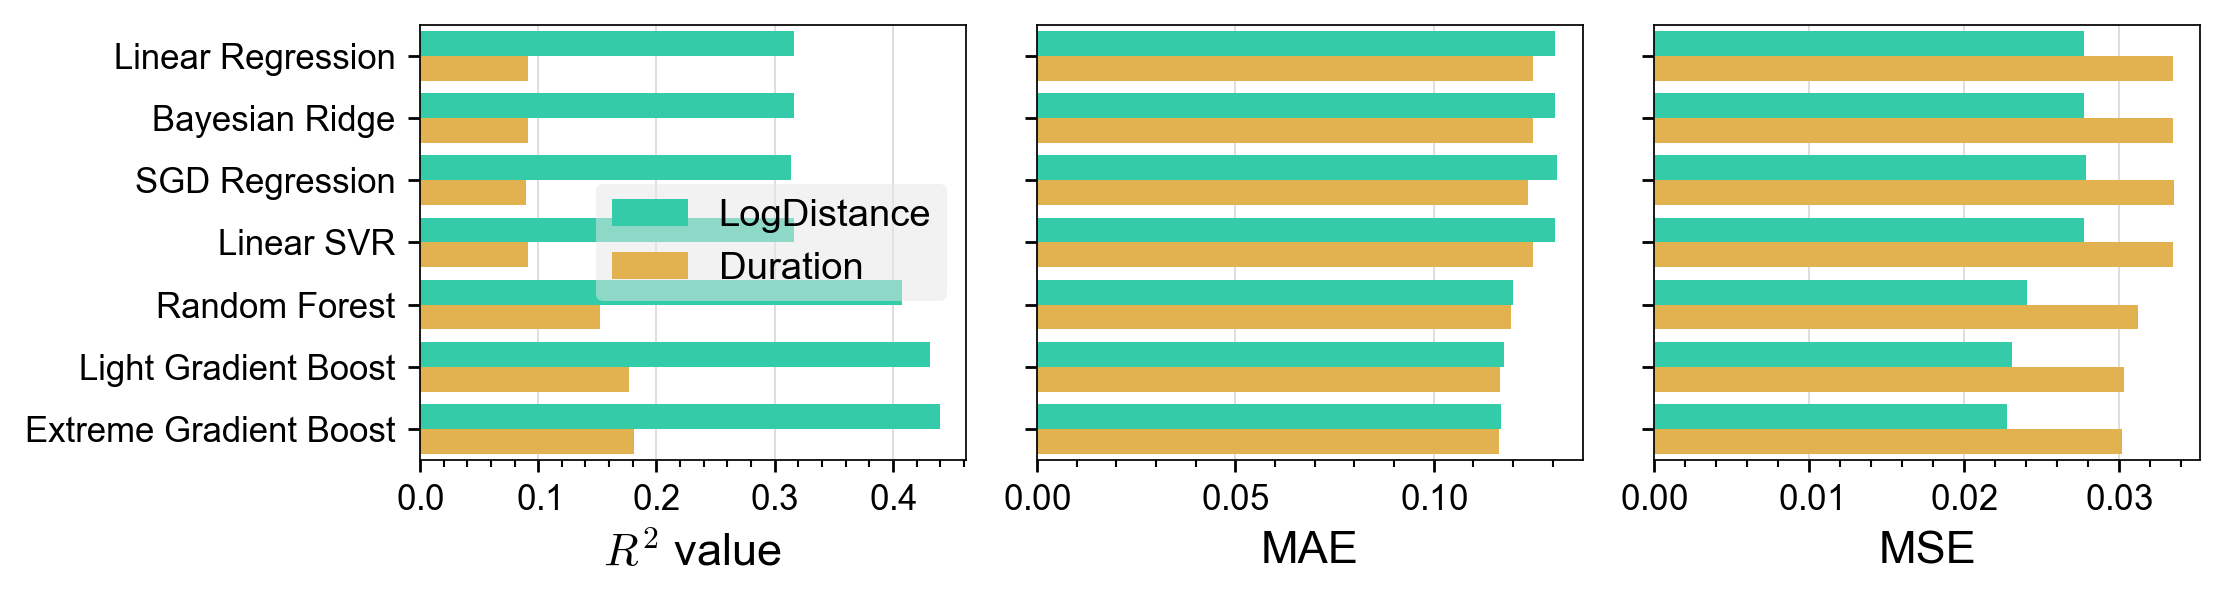

In [11]:
def fig_compare_models(res, size=(9, 2.5), dpi=150):
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi)
    for i, (metric, label) in enumerate([
            ('r2', '$R^2$ value'), ('mae', 'MAE'), ('mse', 'MSE')]):
        ax = pplot(axes[i], xlab=label, yminor=0)
        sns.barplot(res, ax=ax, x=metric, y='model', hue='target', palette='turbo')
        ax.set_ylabel('')
        if i == 0:
            ax.legend_.set_title(None)
        if i > 0:
            ax.legend_.remove()
            ax.set_yticklabels([])
    plt.tight_layout()

fig_compare_models(res_mini, dpi=250)

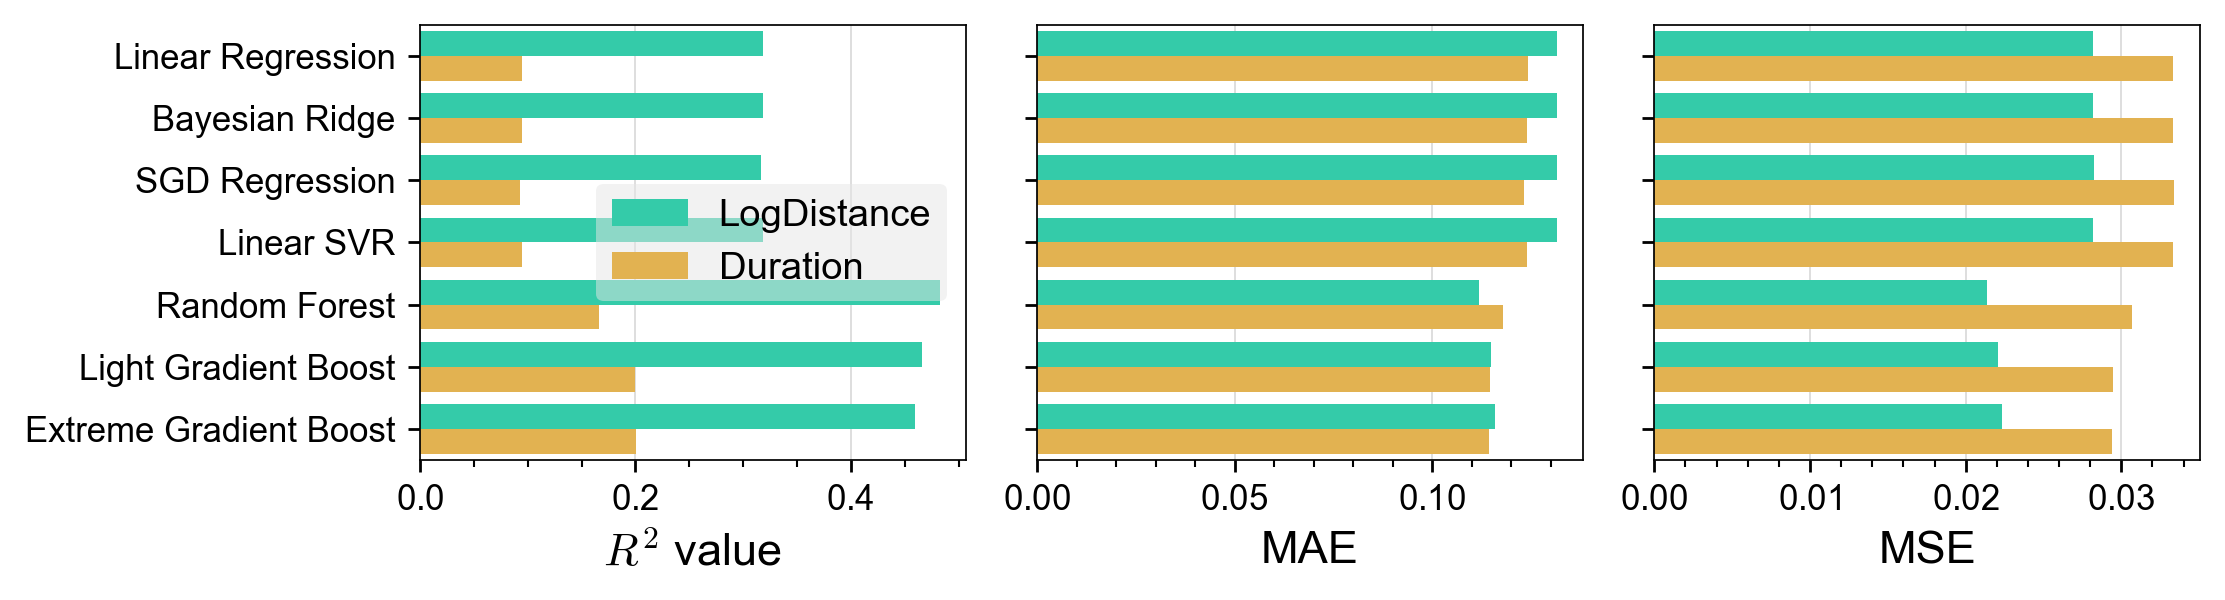

In [12]:
fig_compare_models(res_full, dpi=250)
imsave('Comparison of regression model performance', root='../fig/nhts')

## 2.4. Fit the best model

In [13]:
# t=0:06
best_model_kind = 'Light Gradient Boost'
models = {} # finally selected models
for target in tqdm(['LogDistance', 'Duration']):
    ds = ds_full[target]
    params = (res_mini.query(f'model=="{best_model_kind}" & target=="{target}"')
              .iloc[0].cv.best_params_)
    model = LGBMRegressor(**(params | D(max_depth=-1)), 
                          n_jobs=-1, force_row_wise=True, verbosity=0)
    model.fit(ds.Xtrain, ds.ytrain)
    r2 = r2_score(ds.ytest, model.predict(ds.Xtest))
    print(f'Model R2 value for {target}: {r2:.3f}')
    models[target] = model
models['Duration']

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Model R2 value for LogDistance: 0.435
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Model R2 value for Duration: 0.174


LGBMRegressor(force_row_wise=True, learning_rate=0.05, n_jobs=-1, verbosity=0)

In [14]:
save_pickle(models, '../data/nhts/selected_models.pkl')

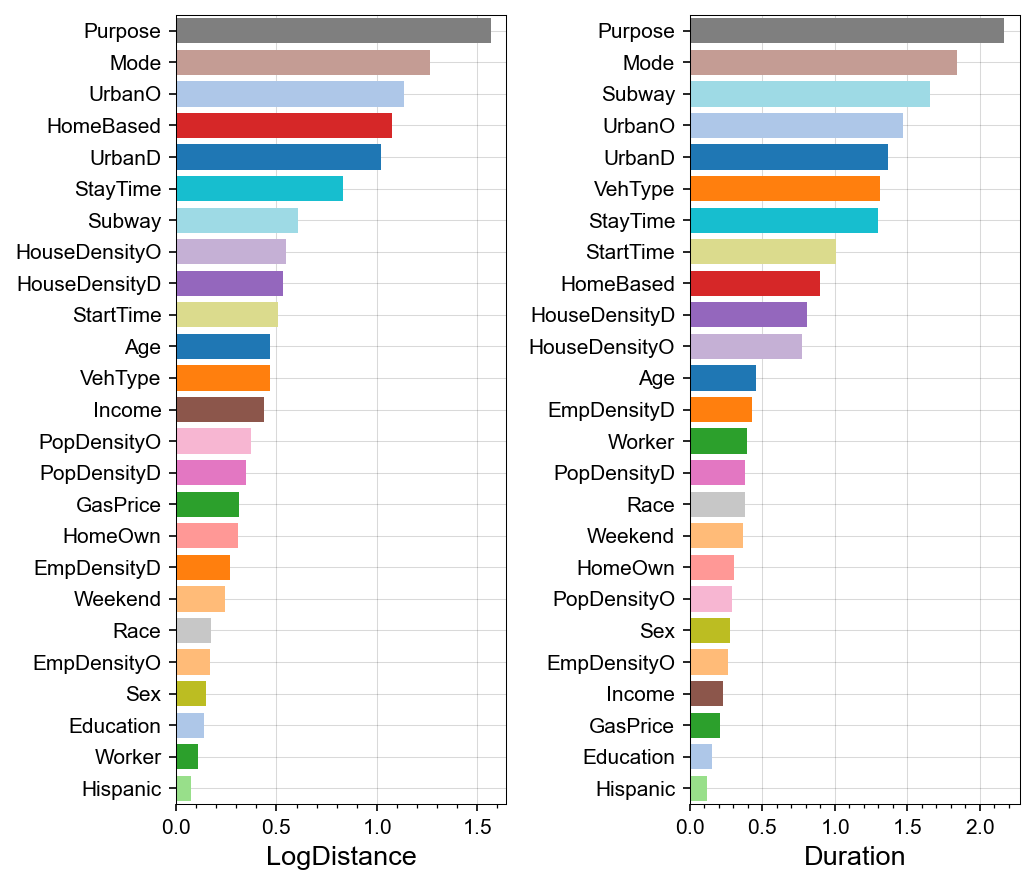

In [15]:
def plot_feature_importance(models, size=(7, 6), dpi=150):
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    for i, (target, model) in enumerate(models.items()):
        df = Pdf(D(factor=model.feature_name_, imp=normalize(model.feature_importances_)))
        df['feature'], df['level'] = list(zip(*df.factor.str.split('__')))
        df = df.groupby('feature')['imp'].sum().sort_values().reset_index()
        df['color'] = df.feature.astype(CAT).cat.codes.map(dict(enumerate(
            sns.color_palette('tab20', df.feature.nunique())))).apply(mpl.colors.to_hex)
        ax = pplot(axes[i], xlab=target, yminor=0)
        ax.set_ylim(-0.5, len(df) - 0.5)
        ax.barh(df.feature, df.imp, color=df.color);
    plt.tight_layout()

plot_feature_importance(models)